In [ ]:
data_directory = "/content/datasets/ravdess"

In [ ]:
root_path = '/'

In [ ]:
import os
os.chdir(root_path)

In [ ]:
!pip install PyDrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
zip_file_path = '/content/gdrive/MyDrive/speech-emotion-recognition-ravdess-data.zip'
destination_dir = '/content/data'
extracted_dir = '/content/datasets/ravdess'

# Create directories if they don't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Copy the zip file to the destination directory
!cp "$zip_file_path" "$destination_dir"

# Navigate to the destination directory
os.chdir(destination_dir)

# Unzip the file into the extracted directory
!unzip -q speech-emotion-recognition-ravdess-data.zip -d "$extracted_dir"

# List the contents of the extracted directory
!ls "$extracted_dir"

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras_utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras_utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=7def9078fd4d1ece9f0fad5636bad35595ce97686e3ca71ed629d4a056b5058d
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras_utils


In [34]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
import keras

In [ ]:
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [ ]:
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):

    """
    extract features from audio files into numpy array

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """

    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))

    return result

In [ ]:
def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [ ]:
def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

In [ ]:
def load_data(save=False):

    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.
        data, sr = librosa.load(file)

        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)

        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y

In [ ]:
X, y = load_data(save=True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [ ]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [ ]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 256)          1536      
                                                                 
 activation (Activation)     (None, 180, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 180, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 180, 128)          0         
                                                                 
 dropout (Dropout)           (None, 180, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 22, 128)           0         
 D)                                                              
                                                        

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/content/model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [ ]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)

history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=32, callbacks = callbacks)

Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 2.0025 - accuracy: 0.2762
Epoch 1: saving model to /content/model_weights.h5
102/102 [==============================] - 27s 269ms/step - loss: 2.0025 - accuracy: 0.2762 - val_loss: 1.9935 - val_accuracy: 0.3185
Epoch 2/100
101/102 [============================>.] - ETA: 0s - loss: 2.0139 - accuracy: 0.2676
Epoch 2: saving model to /content/model_weights.h5
102/102 [==============================] - 27s 266ms/step - loss: 2.0144 - accuracy: 0.2673 - val_loss: 1.9926 - val_accuracy: 0.3130
Epoch 3/100
101/102 [============================>.] - ETA: 0s - loss: 2.0124 - accuracy: 0.2713
Epoch 3: saving model to /content/model_weights.h5
102/102 [==============================] - 17s 162ms/step - loss: 2.0125 - accuracy: 0.2716 - val_loss: 1.9909 - val_accuracy: 0.3157
Epoch 4/100
101/102 [============================>.] - ETA: 0s - loss: 2.0025 - accuracy: 0.2720
Epoch 4: saving model to /content/model_weights.h5
102/10

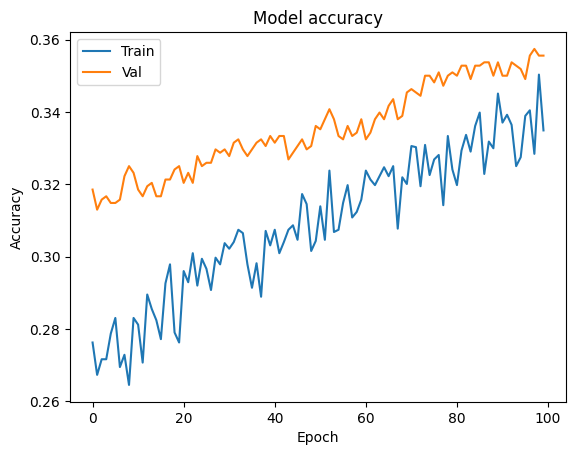

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

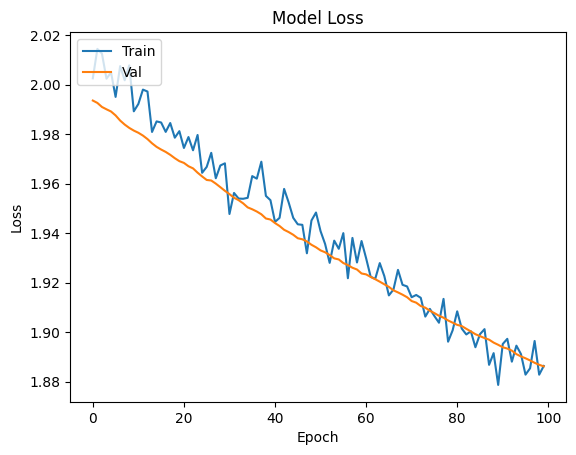

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [27]:
y_pred = model.predict(XTestProcessed)

34/34 [==============================] - 3s 87ms/step


<Axes: >

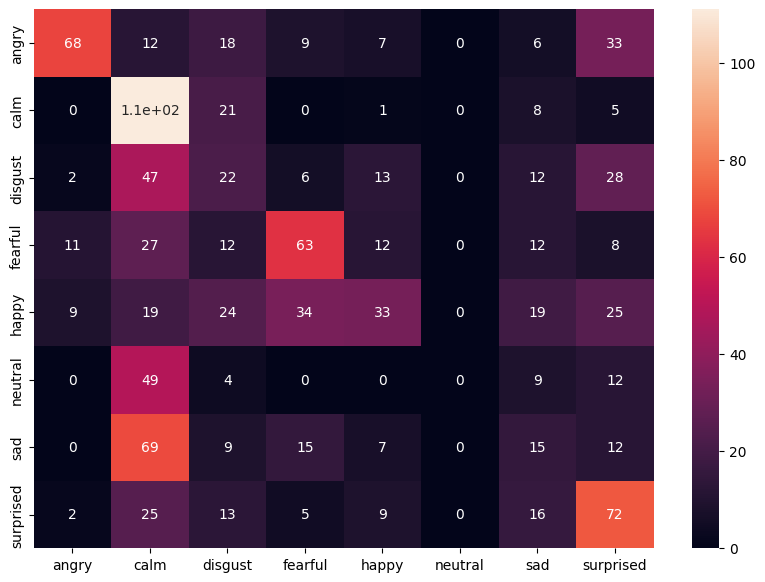

In [28]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [29]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.33266097715909015

In [32]:
if not os.path.exists('models'):
    os.makedirs('models')

model.save("models/cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model_json = model.to_json()
with open("/content/model_a1.json","w") as json_file:
    json_file.write(model_json)

In [35]:
loaded_model = keras.models.load_model("models/cnn.h5")

In [36]:
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [45]:
XX, yy = load_single_data("/content/datasets/ravdess/Actor_09/03-01-03-01-01-01-09.wav")

In [46]:
yy

['happy']